## Jorge Bueno Perez - 419034

## Prediction of the average price of the Spanish rail tickets data 

In [1]:
import numpy as np
import pandas as pd
from ggplot import *
import os
import time

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend" # most important part

from sklearn.linear_model import LassoCV
import keras
import keras.applications as kapp
from keras.datasets import cifar10

Using plaidml.keras.backend backend.


In [2]:
renfe = pd.read_csv("~/Desktop/Projects/DL/Regression/Before_modeling/Datasets/renfe1.csv")

# 1) `Feature enginering`:

### Several `new features` are going to be created:

## - 1.1) `Distance`:

In [3]:
coord = pd.read_csv("~/Desktop/Projects/DL/Regression/Before_modeling/Others/coord_city.csv")

In [4]:
import haversine as hs

### After extracting the `longitude` and `latitude` of the `origin` and `destination` in `Data_exploration`, we are able to extract the `linear distance` between the origin and destination, with the help of the package `haversine`

In [5]:
coord["distance"] = np.nan
for i in range(len(coord)):
    coord.distance.iloc[i] =  round(hs.haversine((coord.origin_lng[i], coord.origin_lat[i]), (coord.destination_lng[i], coord.destination_lat[i])), 2)

/Users/Lajobu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
coord["or_dest"] = coord.origin + coord.destination

In [7]:
renfe["distance"] = np.nan
r = 0
for i in range(len(renfe)):
    try:
        renfe.distance.iloc[i]= np.float(coord[coord['or_dest'].str.contains(str((renfe.origin[i] + renfe.destination[i])))]['distance'])
    except:
        renfe.distance.iloc[i]= max(coord[coord['or_dest'].str.contains(str((renfe.origin[i] + renfe.destination[i])))]['distance'])
    r += 1

## - 1.2) `Seasons`:

### The column `season` is based on `month`, as follows:
- 0: Spring - `January`, `February` and `March`
- 1: Summer - `April`, `May` and `June`
- 2: Autumn - `July`, `August` and `September`
- 3: Winter - `October`, `November` and `December`

In [8]:
renfe['season']= renfe['month'].apply(lambda x: int(x/4)) 

## - 1.3) `Weekend`:

### The feature `weekend` is going to be creasted, this is based on `week_day`:
- `0 - no weekend`
- `1 - weekend`

In [9]:
weekend= []
for i in range(len(renfe)):
    if (renfe.week_day[i] in (0, 1, 2, 3, 4)):
        weekend.append(0) # 0 - no weekend
    else:
        weekend.append(1) # 1 - weekend
renfe["weekend"] = weekend

## - 1.4) `Times of day`:

### The column `time_day` is going to be created as follows:
- `Morning: 6:00 - 11:59 - 0`
- `Afternoon: 12:00 - 18:59 - 1`
- `Evening: 19:00 - 23:59 - 2`
- `Night: 00:00 - 5:59 - 3`

In [10]:
time = []
for i in range(len(renfe)):
    if (renfe['time'][i] >= '6:00') & (renfe['time'][i] <= '11:59'): # morning - 0
        time.append(0)
    elif (renfe['time'][i] >= '12:00') & (renfe['time'][i] <= '18:59'): # afternoon - 1
        time.append(1)
    elif (renfe['time'][i] >= '19:00') & (renfe['time'][i] <= '23:59'): # evening - 2
        time.append(2)
    else: # night - 3
         time.append(3)
renfe["time_day"] = time

# 2) `Variables encoding`:

## - 2.1) `Origin, destination, vehicle_type, vehicle_class and fare`:

### The `characteristic features` are going to be transformed to `integers`

In [11]:
list_= renfe.origin.unique().tolist() + renfe.vehicle_type.unique().tolist() + renfe.vehicle_class.unique().tolist() + renfe.fare.unique().tolist()
col_names = ['origin','vehicle_type', 'vehicle_class', 'fare']
s = {} 
t = 0 
n = 0 
r = 0 
for i in list_:
    if t < len(renfe[col_names[r]].unique().tolist()):
        s[list_[n]] = t
        t += 1
        n += 1
    else:
        t = 0
        s[list_[n]] = t
        t += 1
        n += 1
        r += 1
col_names_ = ['origin', 'destination', 'vehicle_type', 'vehicle_class', 'fare']
for i in col_names_:
    renfe = renfe.replace({i: s})

## - 2.2) `Time`:

### The time will be changed to `seconds`

In [12]:
list_ = renfe.time.sort_values().unique().tolist()
s = {}
r = 0
for i in list_:
    s[i] = r
    r += 1
renfe = renfe.replace({"time": s})

## - 2.3) `Year`:

### The year is going to be transformed to integers:
- `2019 - 0`
- `2020 - 1`

In [13]:
year = []
for i in range(len(renfe)):
    if (renfe['year'][i] == '2019'): # 2019 - 0
        time.append(0)
    else: # 2020 - 1
         year.append(1)
renfe["year"] = year

### After all this transformation we will have `15 columns` and `253458 rows`

In [14]:
renfe.shape 

(253452, 15)

### The dataset contains `2 columns as float points` and `13 columns as integers`

In [15]:
renfe.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253452 entries, 0 to 253451
Data columns (total 15 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   origin         253452 non-null  int64  
 1   destination    253452 non-null  int64  
 2   duration       253452 non-null  int64  
 3   vehicle_type   253452 non-null  int64  
 4   vehicle_class  253452 non-null  int64  
 5   fare           253452 non-null  int64  
 6   price          253452 non-null  float64
 7   week_day       253452 non-null  int64  
 8   month          253452 non-null  int64  
 9   year           253452 non-null  int64  
 10  time           253452 non-null  int64  
 11  distance       253452 non-null  float64
 12  season         253452 non-null  int64  
 13  weekend        253452 non-null  int64  
 14  time_day       253452 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 29.0 MB


# 3) `Features selection`:

### At this point we are going to select features for the model. This step is important to be done after `feature enginering` because it is possible that some created `columns` are not relevant

## - 3.1) `Correlation plot`:

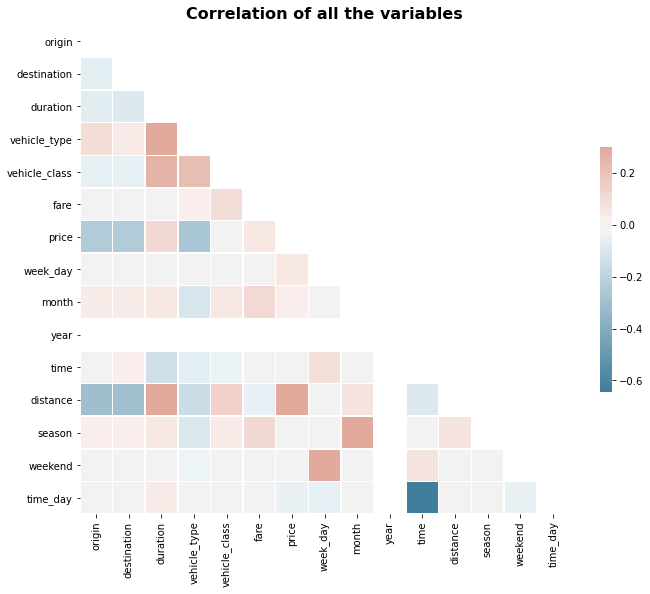

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = renfe.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation of all the variables',
            fontsize=16,
            fontweight='bold')
plt.savefig('~/Desktop/Projects/DL/Regression/Before_modeling/Figures/corr.png')

### It appears that there are not highly correlated features, there is only highly negative correlation between `time` and `time_day`, however the feature `time_day` was created in the `feature enginering`section from `time`, hence this is expected

## - 3.2) `Features by importance - embedded method, lasso`:

### It will be applied `lasso` model in order to figure out the most important features to explain the target variable, `price`

In [17]:
X = renfe.drop(["price"],1) 
y = renfe["price"] 

In [18]:
reg = LassoCV()
reg.fit(X, y)

LassoCV()

In [19]:
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 2.373720
Best score using built-in LassoCV: 0.547332


In [20]:
sel_feat = (coef != 0)[coef != 0].index.values.tolist()
sel_feat

['origin',
 'destination',
 'duration',
 'vehicle_type',
 'fare',
 'week_day',
 'month',
 'time',
 'distance']

In [21]:
unsel_feat = (coef == 0)[coef == 0].index.values.tolist()
unsel_feat

['vehicle_class', 'year', 'season', 'weekend', 'time_day']

### The model `selected`:
- `origin`
- `destination`
- `duration`
- `vehicle_type`
- `fare`
- `week_day`
- `month`
- `time`
- `distance`

### The model `unselected`:
- `vehicle_class`
- `year`
- `season`
- `weekend`
- `time_day`

### We can see the same results in the `vertical bar plot`:

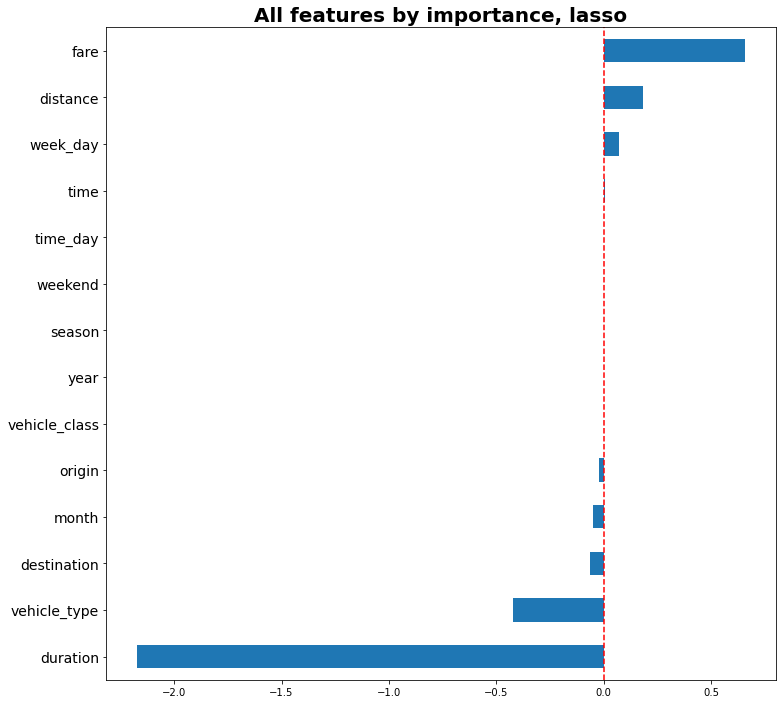

In [22]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (12, 12)
imp_coef.plot(kind = "barh")
plt.title("All features by importance, lasso", size=20, fontweight="bold")
plt.axvline(0, color='r', linestyle='--')
plt.tick_params(axis='y', labelsize=14)
plt.savefig('~/Desktop/Projects/DL/Regression/Before_modeling/Figures/feat_import.png')

## - 3.3) `Correlation plot`, after feature selection:

### The `unselected features` described in previous step, are going to be `omitted in the below correlation plot`

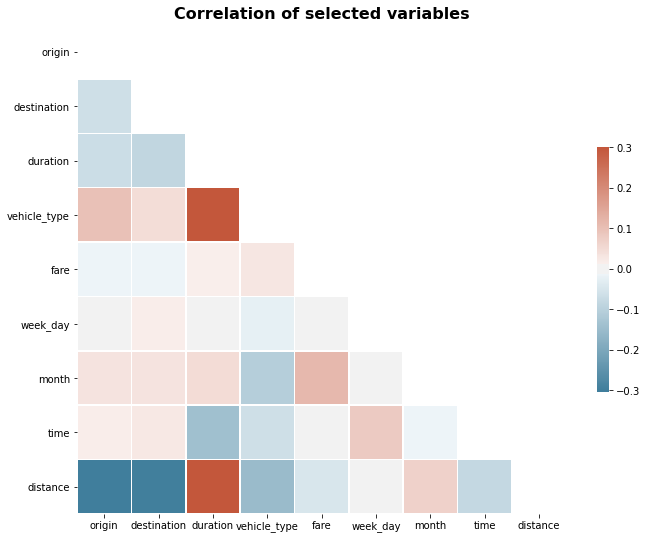

In [23]:
corr = renfe[sel_feat].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title('Correlation of selected variables',
            fontsize=16,
            fontweight='bold')
plt.savefig('~/Desktop/Projects/DL/Regression/Before_modeling/Figures/corr1.png')

### It looks like the `variables are not highly negative or positive correlated`

## - 3.2) `Features by importance - embedded method, lasso`, from the selected features:

In [24]:
X_ = renfe[sel_feat] 
reg = LassoCV()
reg.fit(X_, y)
coef_ = pd.Series(reg.coef_, index = X_.columns)

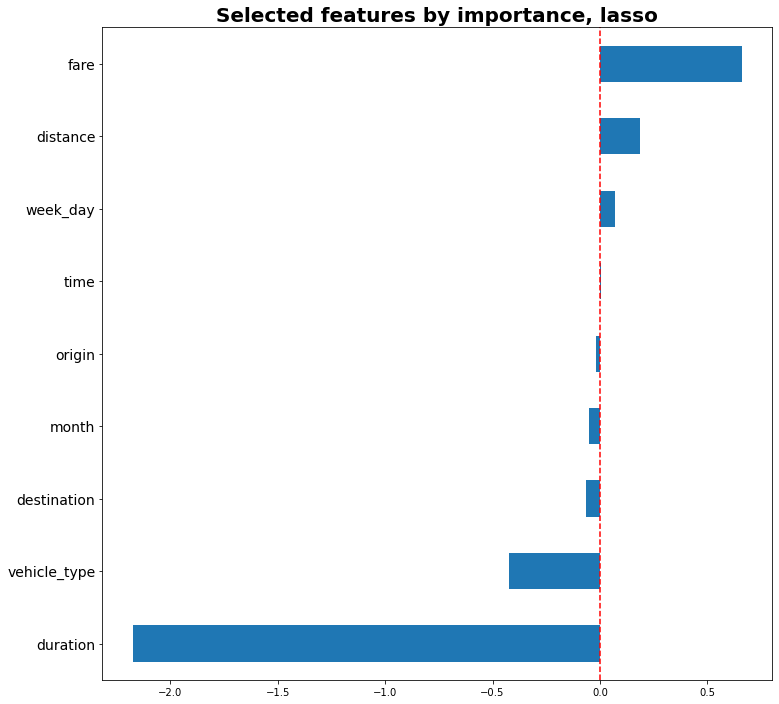

In [25]:
imp_coef = coef_.sort_values()
plt.rcParams['figure.figsize'] = (12, 12)
imp_coef.plot(kind = "barh")
plt.title("Selected features by importance, lasso", size=20, fontweight="bold")
plt.axvline(0, color='r', linestyle='--')
plt.tick_params(axis='y', labelsize=14)
plt.savefig('~/Desktop/Projects/DL/Regression/Before_modeling/Figures/feat_import1.png')

### It seems that the most important features are `duration` and `fare`, and `time` does not appear to be really important

### The below features are going to be used:
- `origin`
- `destination`
- `duration`
- `vehicle_type`
- `fare`
- `week_day`
- `month`
- `time`
- `distance`

### As it can be seen as per the above features, only `distance` created by `feature enginering` was selected, hence we will have 9 columns and one more for the target variable

In [26]:
sel_feat.append("price")
renfe = renfe[sel_feat]

In [27]:
#renfe.to_csv("~/Desktop/Projects/DL/Regression/renfe2.csv", index=False)

### Below there is a list of the equivalences of the data transformation, in case it is needed during the models:

In [28]:
""" Origin & Destination:
'ALBACETE': 0,
 'ALICANTE': 1,
 'BARCELONA': 2,
 'CADIZ': 3,
 'CASTELLO': 4,
 'CASTELLON': 5,
 'CIUDAD REAL': 6,
 'CORDOBA': 7,
 'CUENCA': 8,
 'CÓRDOBA': 9,
 'GIRONA': 10,
 'GRANADA': 11,
 'GUADALAJARA': 12,
 'HUESCA': 13,
 'LEON': 14,
 'LEÓN': 15,
 'LLEIDA': 16,
 'MADRID': 17,
 'MALAGA': 18,
 'MÁLAGA': 19,
 'PALENCIA': 20,
 'PONFERRADA': 21,
 'SEGOVIA': 22,
 'SEVILLA': 23,
 'TARRAGONA': 24,
 'TOLEDO': 25,
 'VALENCIA': 26,
 'VALLADOLID': 27,
 'ZAMORA': 28,
 'ZARAGOZA': 29,
 
 # Vehicle type:
 'AVE': 0,
 'ALTARIA': 1,
 'MD': 2,
 'INTERCITY': 3,
 'ALVIA': 4,
 'REG.EXP.': 5,
 'MD-LD': 6,
 'Intercity': 7,
 'MD-AVE': 8,
 'LD-AVE': 9,
 'R. EXPRES': 10,
 'AVE-TGV': 11,
 'LD': 12,
 'AVLO': 13,
 'LD-MD': 14,
 'EUROMED': 15,
 'TORRE ORO': 16,
 'AVANT': 17,
 'AV City': 18,
 'REGIONAL': 19,
 'AVANT-AVE': 20,
 'LD-AVANT': 21,
 'TRENHOTEL': 22,
 'MD-AVANT': 23,
 'AVE-MD': 24,
 'AVE-LD': 25,
 'AVE-AVANT': 26,
 'AVE-AVE': 27,
 'AVANT-LD': 28,
 'AVANT-MD': 29,
 
 # Vehicle class:
 'Preferente': 0,
 'Turista': 1,
 'Turista con enlace': 2,
 'Turista Plus': 3,
 'TuristaSólo plaza H': 4,
 'Turista Plus - Turista': 5,
 'Cama Turista': 6,
 'Turista - Turista Plus': 7,
 'Cama G. Clase': 8,
 'PreferenteSólo plaza H': 9,
 'Turista PlusSólo plaza H': 10,
 
 # Fare
 'Promo': 0,
 'Adulto ida': 1,
 'Flexible': 2,
 'Promo +': 3,
 'YOVOY': 4,
 'COD.PROMOCIONAL': 5,
 'Grupos Ida': 6,
 'Mesa': 7,
 'Básica': 8,
 'Doble Familiar-Flexible': 9,
 'Individual-Flexible': 10
 
 # Time:
 '02:36': 0,
 '04:12': 1,
 '04:25': 2,
 '05:15': 3,
 '05:30': 4,
 '05:36': 5,
 '05:40': 6,
 '05:50': 7,
 '06:05': 8,
 '06:08': 9,
 '06:10': 10,
 '06:11': 11,
 '06:13': 12,
 '06:15': 13,
 '06:18': 14,
 '06:20': 15,
 '06:23': 16,
 '06:25': 17,
 '06:28': 18,
 '06:30': 19,
 '06:33': 20,
 '06:38': 21,
 '06:39': 22,
 '06:40': 23,
 '06:42': 24,
 '06:43': 25,
 '06:45': 26,
 '06:46': 27,
 '06:50': 28,
 '06:52': 29,
 '06:53': 30,
 '06:55': 31,
 '07:00': 32,
 '07:01': 33,
 '07:02': 34,
 '07:04': 35,
 '07:05': 36,
 '07:07': 37,
 '07:08': 38,
 '07:10': 39,
 '07:14': 40,
 '07:15': 41,
 '07:16': 42,
 '07:17': 43,
 '07:20': 44,
 '07:22': 45,
 '07:24': 46,
 '07:25': 47,
 '07:26': 48,
 '07:28': 49,
 '07:29': 50,
 '07:30': 51,
 '07:35': 52,
 '07:36': 53,
 '07:40': 54,
 '07:43': 55,
 '07:45': 56,
 '07:46': 57,
 '07:47': 58,
 '07:48': 59,
 '07:49': 60,
 '07:50': 61,
 '07:51': 62,
 '07:52': 63,
 '07:55': 64,
 '07:57': 65,
 '07:59': 66,
 '08:00': 67,
 '08:03': 68,
 '08:04': 69,
 '08:05': 70,
 '08:06': 71,
 '08:07': 72,
 '08:09': 73,
 '08:10': 74,
 '08:11': 75,
 '08:12': 76,
 '08:14': 77,
 '08:15': 78,
 '08:20': 79,
 '08:22': 80,
 '08:25': 81,
 '08:26': 82,
 '08:27': 83,
 '08:30': 84,
 '08:31': 85,
 '08:32': 86,
 '08:33': 87,
 '08:34': 88,
 '08:35': 89,
 '08:38': 90,
 '08:40': 91,
 '08:42': 92,
 '08:45': 93,
 '08:48': 94,
 '08:50': 95,
 '08:52': 96,
 '08:55': 97,
 '08:56': 98,
 '08:57': 99,
 '08:58': 100,
 '08:59': 101,
 '09:00': 102,
 '09:03': 103,
 '09:07': 104,
 '09:10': 105,
 '09:12': 106,
 '09:15': 107,
 '09:16': 108,
 '09:19': 109,
 '09:20': 110,
 '09:22': 111,
 '09:23': 112,
 '09:25': 113,
 '09:26': 114,
 '09:29': 115,
 '09:30': 116,
 '09:32': 117,
 '09:35': 118,
 '09:36': 119,
 '09:38': 120,
 '09:40': 121,
 '09:41': 122,
 '09:43': 123,
 '09:45': 124,
 '09:46': 125,
 '09:47': 126,
 '09:50': 127,
 '09:52': 128,
 '09:54': 129,
 '09:59': 130,
 '10:00': 131,
 '10:03': 132,
 '10:05': 133,
 '10:07': 134,
 '10:10': 135,
 '10:11': 136,
 '10:12': 137,
 '10:15': 138,
 '10:18': 139,
 '10:20': 140,
 '10:22': 141,
 '10:25': 142,
 '10:26': 143,
 '10:27': 144,
 '10:30': 145,
 '10:32': 146,
 '10:33': 147,
 '10:35': 148,
 '10:37': 149,
 '10:38': 150,
 '10:39': 151,
 '10:40': 152,
 '10:42': 153,
 '10:43': 154,
 '10:45': 155,
 '10:46': 156,
 '10:47': 157,
 '10:50': 158,
 '10:51': 159,
 '10:53': 160,
 '10:54': 161,
 '10:55': 162,
 '10:57': 163,
 '10:59': 164,
 '11:00': 165,
 '11:02': 166,
 '11:03': 167,
 '11:05': 168,
 '11:10': 169,
 '11:11': 170,
 '11:12': 171,
 '11:13': 172,
 '11:15': 173,
 '11:16': 174,
 '11:20': 175,
 '11:23': 176,
 '11:25': 177,
 '11:27': 178,
 '11:28': 179,
 '11:29': 180,
 '11:30': 181,
 '11:35': 182,
 '11:38': 183,
 '11:40': 184,
 '11:43': 185,
 '11:44': 186,
 '11:45': 187,
 '11:46': 188,
 '11:48': 189,
 '11:50': 190,
 '11:52': 191,
 '11:53': 192,
 '11:55': 193,
 '11:56': 194,
 '11:57': 195,
 '11:58': 196,
 '11:59': 197,
 '12:00': 198,
 '12:02': 199,
 '12:04': 200,
 '12:05': 201,
 '12:07': 202,
 '12:10': 203,
 '12:12': 204,
 '12:13': 205,
 '12:15': 206,
 '12:18': 207,
 '12:20': 208,
 '12:21': 209,
 '12:25': 210,
 '12:26': 211,
 '12:29': 212,
 '12:30': 213,
 '12:32': 214,
 '12:33': 215,
 '12:36': 216,
 '12:40': 217,
 '12:42': 218,
 '12:43': 219,
 '12:46': 220,
 '12:50': 221,
 '12:51': 222,
 '12:52': 223,
 '12:56': 224,
 '12:59': 225,
 '13:00': 226,
 '13:05': 227,
 '13:10': 228,
 '13:11': 229,
 '13:15': 230,
 '13:16': 231,
 '13:18': 232,
 '13:25': 233,
 '13:26': 234,
 '13:30': 235,
 '13:33': 236,
 '13:35': 237,
 '13:36': 238,
 '13:38': 239,
 '13:40': 240,
 '13:43': 241,
 '13:44': 242,
 '13:45': 243,
 '13:46': 244,
 '13:50': 245,
 '13:59': 246,
 '14:00': 247,
 '14:05': 248,
 '14:06': 249,
 '14:07': 250,
 '14:09': 251,
 '14:10': 252,
 '14:12': 253,
 '14:15': 254,
 '14:16': 255,
 '14:17': 256,
 '14:19': 257,
 '14:20': 258,
 '14:21': 259,
 '14:24': 260,
 '14:25': 261,
 '14:30': 262,
 '14:32': 263,
 '14:33': 264,
 '14:35': 265,
 '14:36': 266,
 '14:40': 267,
 '14:42': 268,
 '14:43': 269,
 '14:45': 270,
 '14:47': 271,
 '14:50': 272,
 '14:51': 273,
 '14:55': 274,
 '14:57': 275,
 '14:58': 276,
 '14:59': 277,
 '15:00': 278,
 '15:04': 279,
 '15:05': 280,
 '15:06': 281,
 '15:10': 282,
 '15:11': 283,
 '15:15': 284,
 '15:16': 285,
 '15:20': 286,
 '15:22': 287,
 '15:25': 288,
 '15:28': 289,
 '15:29': 290,
 '15:30': 291,
 '15:32': 292,
 '15:33': 293,
 '15:35': 294,
 '15:39': 295,
 '15:40': 296,
 '15:43': 297,
 '15:44': 298,
 '15:45': 299,
 '15:47': 300,
 '15:50': 301,
 '15:52': 302,
 '15:54': 303,
 '15:55': 304,
 '15:57': 305,
 '15:58': 306,
 '15:59': 307,
 '16:00': 308,
 '16:01': 309,
 '16:02': 310,
 '16:03': 311,
 '16:05': 312,
 '16:07': 313,
 '16:10': 314,
 '16:12': 315,
 '16:15': 316,
 '16:16': 317,
 '16:17': 318,
 '16:18': 319,
 '16:20': 320,
 '16:21': 321,
 '16:22': 322,
 '16:24': 323,
 '16:25': 324,
 '16:26': 325,
 '16:27': 326,
 '16:28': 327,
 '16:29': 328,
 '16:30': 329,
 '16:32': 330,
 '16:33': 331,
 '16:35': 332,
 '16:38': 333,
 '16:39': 334,
 '16:40': 335,
 '16:43': 336,
 '16:44': 337,
 '16:45': 338,
 '16:48': 339,
 '16:50': 340,
 '16:52': 341,
 '16:55': 342,
 '16:56': 343,
 '16:59': 344,
 '17:00': 345,
 '17:01': 346,
 '17:02': 347,
 '17:03': 348,
 '17:04': 349,
 '17:05': 350,
 '17:10': 351,
 '17:12': 352,
 '17:14': 353,
 '17:15': 354,
 '17:20': 355,
 '17:21': 356,
 '17:22': 357,
 '17:25': 358,
 '17:26': 359,
 '17:28': 360,
 '17:29': 361,
 '17:30': 362,
 '17:32': 363,
 '17:34': 364,
 '17:35': 365,
 '17:36': 366,
 '17:38': 367,
 '17:40': 368,
 '17:43': 369,
 '17:45': 370,
 '17:46': 371,
 '17:47': 372,
 '17:48': 373,
 '17:50': 374,
 '17:51': 375,
 '17:54': 376,
 '17:55': 377,
 '17:56': 378,
 '18:00': 379,
 '18:02': 380,
 '18:05': 381,
 '18:07': 382,
 '18:10': 383,
 '18:11': 384,
 '18:15': 385,
 '18:22': 386,
 '18:25': 387,
 '18:26': 388,
 '18:27': 389,
 '18:29': 390,
 '18:30': 391,
 '18:31': 392,
 '18:32': 393,
 '18:33': 394,
 '18:35': 395,
 '18:36': 396,
 '18:37': 397,
 '18:38': 398,
 '18:39': 399,
 '18:40': 400,
 '18:43': 401,
 '18:44': 402,
 '18:45': 403,
 '18:47': 404,
 '18:50': 405,
 '18:52': 406,
 '18:53': 407,
 '18:54': 408,
 '18:55': 409,
 '18:56': 410,
 '18:59': 411,
 '19:00': 412,
 '19:01': 413,
 '19:04': 414,
 '19:05': 415,
 '19:08': 416,
 '19:10': 417,
 '19:11': 418,
 '19:12': 419,
 '19:13': 420,
 '19:14': 421,
 '19:15': 422,
 '19:16': 423,
 '19:17': 424,
 '19:18': 425,
 '19:19': 426,
 '19:20': 427,
 '19:25': 428,
 '19:29': 429,
 '19:30': 430,
 '19:32': 431,
 '19:35': 432,
 '19:36': 433,
 '19:40': 434,
 '19:41': 435,
 '19:43': 436,
 '19:45': 437,
 '19:46': 438,
 '19:50': 439,
 '19:55': 440,
 '19:56': 441,
 '19:57': 442,
 '19:58': 443,
 '20:00': 444,
 '20:01': 445,
 '20:02': 446,
 '20:05': 447,
 '20:06': 448,
 '20:08': 449,
 '20:10': 450,
 '20:13': 451,
 '20:14': 452,
 '20:15': 453,
 '20:20': 454,
 '20:23': 455,
 '20:25': 456,
 '20:26': 457,
 '20:27': 458,
 '20:28': 459,
 '20:29': 460,
 '20:30': 461,
 '20:31': 462,
 '20:33': 463,
 '20:35': 464,
 '20:36': 465,
 '20:37': 466,
 '20:38': 467,
 '20:40': 468,
 '20:41': 469,
 '20:43': 470,
 '20:45': 471,
 '20:46': 472,
 '20:50': 473,
 '20:55': 474,
 '20:59': 475,
 '21:00': 476,
 '21:03': 477,
 '21:05': 478,
 '21:06': 479,
 '21:08': 480,
 '21:09': 481,
 '21:10': 482,
 '21:12': 483,
 '21:15': 484,
 '21:18': 485,
 '21:20': 486,
 '21:21': 487,
 '21:22': 488,
 '21:25': 489,
 '21:26': 490,
 '21:27': 491,
 '21:28': 492,
 '21:29': 493,
 '21:30': 494,
 '21:31': 495,
 '21:32': 496,
 '21:33': 497,
 '21:36': 498,
 '21:37': 499,
 '21:42': 500,
 '21:43': 501,
 '21:45': 502,
 '21:46': 503,
 '21:47': 504,
 '21:48': 505,
 '21:50': 506,
 '21:55': 507,
 '21:56': 508,
 '21:59': 509,
 '22:00': 510,
 '22:05': 511,
 '22:08': 512,
 '22:11': 513,
 '22:14': 514,
 '22:15': 515,
 '22:24': 516,
 '22:25': 517,
 '22:31': 518,
 '22:43': 519,
 '22:55': 520,
 '23:40': 521
 
 # Year:
 '2019': 0,
 '2020': 1 """

" Origin & Destination:\n'ALBACETE': 0,\n 'ALICANTE': 1,\n 'BARCELONA': 2,\n 'CADIZ': 3,\n 'CASTELLO': 4,\n 'CASTELLON': 5,\n 'CIUDAD REAL': 6,\n 'CORDOBA': 7,\n 'CUENCA': 8,\n 'CÓRDOBA': 9,\n 'GIRONA': 10,\n 'GRANADA': 11,\n 'GUADALAJARA': 12,\n 'HUESCA': 13,\n 'LEON': 14,\n 'LEÓN': 15,\n 'LLEIDA': 16,\n 'MADRID': 17,\n 'MALAGA': 18,\n 'MÁLAGA': 19,\n 'PALENCIA': 20,\n 'PONFERRADA': 21,\n 'SEGOVIA': 22,\n 'SEVILLA': 23,\n 'TARRAGONA': 24,\n 'TOLEDO': 25,\n 'VALENCIA': 26,\n 'VALLADOLID': 27,\n 'ZAMORA': 28,\n 'ZARAGOZA': 29,\n \n # Vehicle type:\n 'AVE': 0,\n 'ALTARIA': 1,\n 'MD': 2,\n 'INTERCITY': 3,\n 'ALVIA': 4,\n 'REG.EXP.': 5,\n 'MD-LD': 6,\n 'Intercity': 7,\n 'MD-AVE': 8,\n 'LD-AVE': 9,\n 'R. EXPRES': 10,\n 'AVE-TGV': 11,\n 'LD': 12,\n 'AVLO': 13,\n 'LD-MD': 14,\n 'EUROMED': 15,\n 'TORRE ORO': 16,\n 'AVANT': 17,\n 'AV City': 18,\n 'REGIONAL': 19,\n 'AVANT-AVE': 20,\n 'LD-AVANT': 21,\n 'TRENHOTEL': 22,\n 'MD-AVANT': 23,\n 'AVE-MD': 24,\n 'AVE-LD': 25,\n 'AVE-AVANT': 26,\n 'AVE-AV